In [193]:
import random
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

## Load data

In [283]:
adata_epi = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')
adata_tme = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.TME.h5ad')

In [284]:
adata_epi_tumor = adata_epi[adata_epi.obs['Manual_CellType_lvl_1']=='Tumor epithelial'].copy()

In [23]:
adata_tme.obs.columns

Index(['doublet_score', 'predicted_doublet', 'SampleID', 'PatientID',
       'BiopsySite', 'Accession', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'Identifier', 'Author_CellType_lvl_1', 'Author_CellType_lvl_2',
       'n_genes', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'MSI', 'Response',
       'Manual_CellType_lvl_1', 'leiden_res_0.1', 'leiden_res_0.2',
       'Manual_CellType_lvl_2'],
      dtype='object')

In [22]:
adata_epi.obs.columns

Index(['doublet_score', 'predicted_doublet', 'SampleID', 'PatientID',
       'BiopsySite', 'Accession', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'Identifier', 'Author_CellType_lvl_1', 'Author_CellType_lvl_2',
       'n_genes', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'MSI', 'Response',
       'leiden', 'Manual_CellType_lvl_1', 'TumorLocation', 'TumorStage',
       'TumorRegressionRatio', 'CancerType', 'Age', 'iCMS3_up', 'iCMS3_dw',
       'iCMS2_up', 'iCMS2_dw', 'AvgSTRDiff_scaled', 'StdSTRDiff_scaled'],
      dtype='object')

## Calculate Antigen presenting score

In [285]:
adata_epi_tumor = adata_epi_tumor.raw.to_adata()
sc.pp.normalize_total(adata_epi_tumor)
sc.pp.log1p(adata_epi_tumor)

In [468]:
APG = [
    'HLA-A',
    'HLA-B',
    'HLA-C',
    'B2M',
    
    # 'TAP1',
    # 'TAP2',
    # 'TAPBP',
    # 'CALR',
    # 'PDIA3',
]

sc.tl.score_genes(adata_epi_tumor, APG, score_name='AP_score')

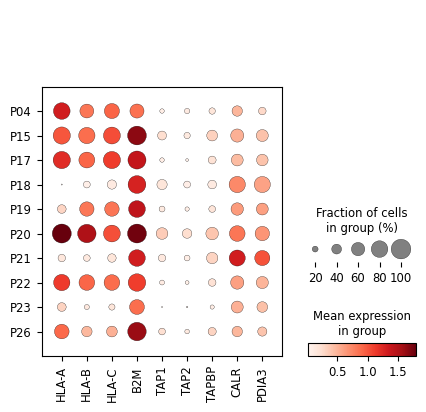

In [287]:
sc.pl.dotplot(adata_epi_tumor[adata_epi_tumor.obs['Manual_CellType_lvl_1']=='Tumor epithelial'], var_names=APG, groupby='PatientID')

## Calculate cMS gene expression

In [84]:
PutativeNeoantigens = pd.read_csv('/node200data/18parkky/datasets/data/FGL/processed_data/cMS_analysis/PutativeNeoproteins.tsv', sep='\t')

In [86]:
dict_cMSlength_to_gene = { RepeatLength : list(set(edf['gene'])) for RepeatLength, edf in PutativeNeoantigens.groupby('RepeatLength') }

,Transcript,RepeatUnit,RepeatLength,WtLength,MutLength,stopFound,cMS_relative_pos,dist,relative_dist,WtPeptide,MutPeptide,LengthDiff,gene
0,A1CF-201_-,A,6,594,84,True,12,510,85.86,MESNHKSGDGLSGTQKEAALRALVQRTGYSLVQENGQRKYGGPPPG...,MESNHKSGDGLSGTQKEAALRALVQRTGYSLVQENGQRKYGGPPPG...,-510,A1CF
1,A1CF-201_-,C,6,594,383,True,58,218,36.70,MESNHKSGDGLSGTQKEAALRALVQRTGYSLVQENGQRKYGGPPPG...,MESNHKSGDGLSGTQKEAALRALVQRTGYSLVQENGQRKYGGPPPG...,-211,A1CF


In [456]:
min_cMS_length = 9
cMS_genes = list()
for cMS_length in range( min_cMS_length, min_cMS_length+1000 ):
    try:
        for g in dict_cMSlength_to_gene[cMS_length]:
            cMS_genes.append( g )
    except KeyError: continue
len(cMS_genes)

378

In [477]:
sc.tl.score_genes(adata_epi_tumor, ['MLH1'], score_name='MLH1_score')

In [469]:
sc.tl.score_genes(adata_epi_tumor, cMS_genes, score_name='cMS_score')

       'TMEM276', 'ENST00000638568_+', 'MARS1', 'ZC3H11C', 'POTEA',
       'ENST00000609618_+', 'TAS2R50', 'FAM9A', 'MYH7', 'GOT1L1', 'BRD10',
       'ENST00000506502_+', 'MUC15', 'ENST00000514667_', 'AADACL3',
       'ENST00000557565_+', 'OR5H8', 'ENST00000505001_+', 'OR52N5', 'OR7E24',
       'CRYAA', 'ENST00000505635_', 'ENST00000515156_+', 'ENST00000672116_',
       'ENST00000718358_+', 'OR6C76', 'ENST00000718364_+',
       'ENST00000614465_+'],
      dtype='object')


In [470]:
u, s = np.mean( adata_epi_tumor.obs['AvgSTRDiff'] ), np.std( adata_epi_tumor.obs['AvgSTRDiff'] )
adata_epi_tumor.obs['AvgSTRDiff_scaled'] = [ (ASD-u)/s for ASD in adata_epi_tumor.obs['AvgSTRDiff'] ]

u, s = np.mean( adata_epi_tumor.obs['StdSTRDiff'] ), np.std( adata_epi_tumor.obs['StdSTRDiff'] )
adata_epi_tumor.obs['StdSTRDiff_scaled'] = [ (ASD-u)/s for ASD in adata_epi_tumor.obs['StdSTRDiff'] ]

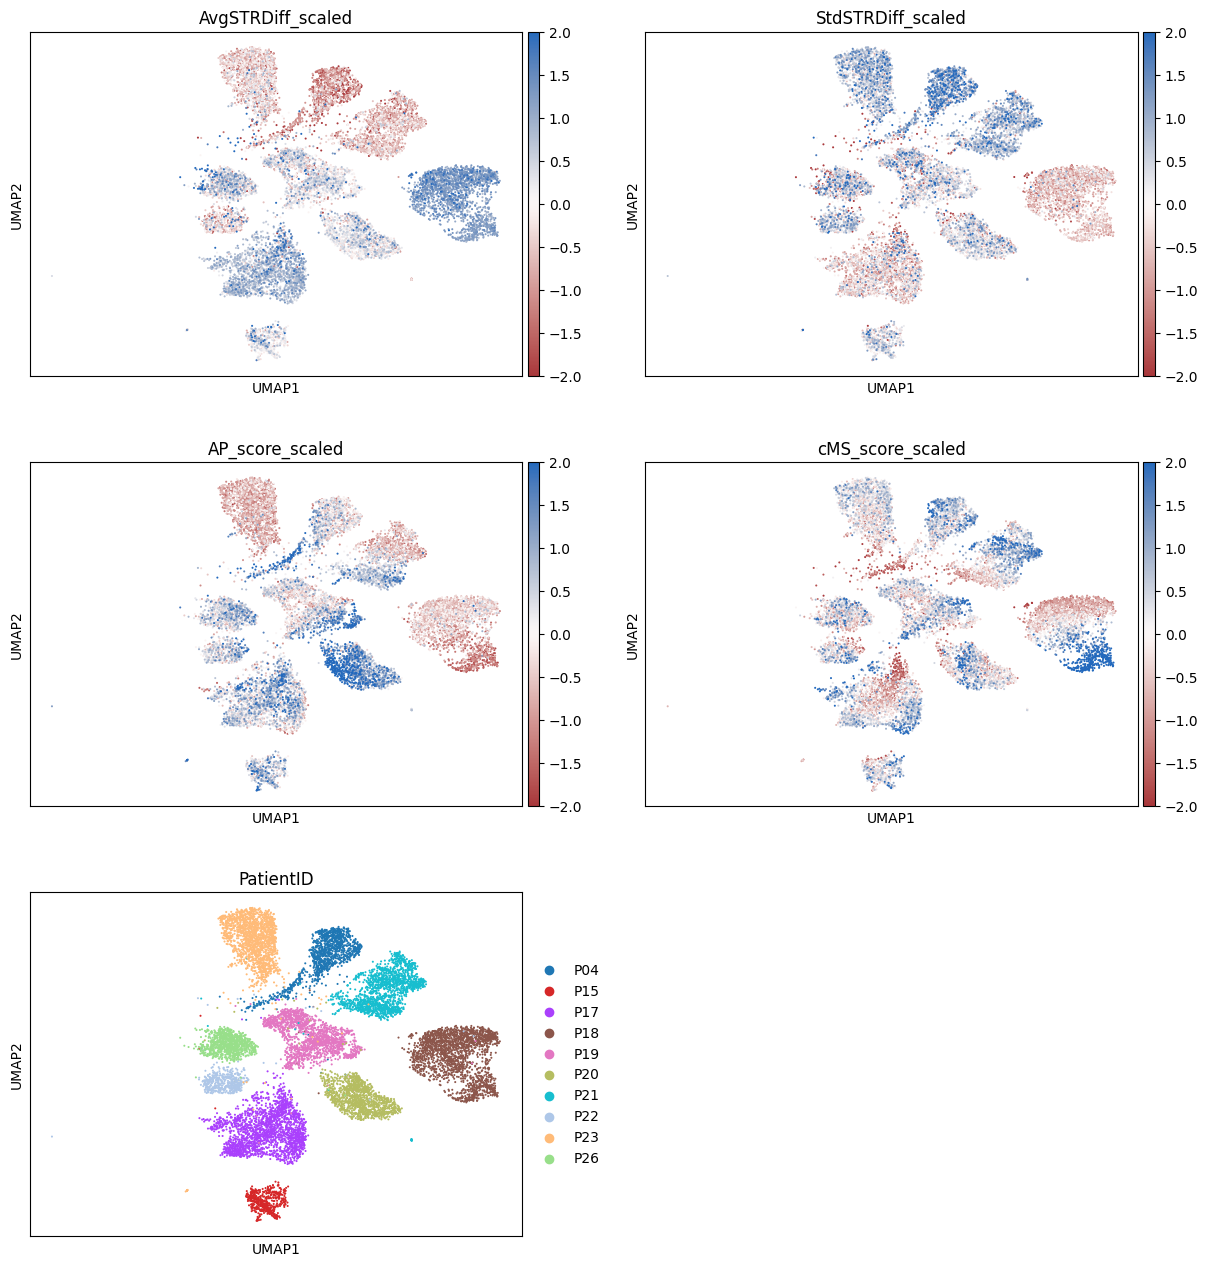

In [423]:
sc.pl.umap(adata_epi_tumor, color=['AvgSTRDiff_scaled', 'StdSTRDiff_scaled', 'AP_score_scaled', 'cMS_score_scaled',], vmin=-2, vmax=2, cmap='vlag_r', ncols=2)

In [480]:
u, s = np.mean( adata_epi_tumor.obs['AP_score'] ), np.std( adata_epi_tumor.obs['AP_score'] )
adata_epi_tumor.obs['AP_score_scaled'] = [ (ASD-u)/s for ASD in adata_epi_tumor.obs['AP_score'] ]

u, s = np.mean( adata_epi_tumor.obs['cMS_score'] ), np.std( adata_epi_tumor.obs['cMS_score'] )
adata_epi_tumor.obs['cMS_score_scaled'] = [ (ASD-u)/s for ASD in adata_epi_tumor.obs['cMS_score'] ]

u, s = np.mean( adata_epi_tumor.obs['MLH1_score'] ), np.std( adata_epi_tumor.obs['MLH1_score'] )
adata_epi_tumor.obs['MLH1_score_scaled'] = [ (ASD-u)/s for ASD in adata_epi_tumor.obs['MLH1_score'] ]

In [481]:
SummaryByPatient = adata_epi_tumor[(adata_epi_tumor.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].obs.groupby(['PatientID'], observed=True)[['AvgSTRDiff_scaled', 'StdSTRDiff_scaled', 
                                                                                                                       'AP_score_scaled', 'cMS_score_scaled', 'MLH1_score_scaled',
                                                                                                                       'TumorRegressionRatio',]].aggregate(np.mean).reset_index().sort_values('AvgSTRDiff_scaled')

/tmp/ipykernel_12432/766865493.py:3: FutureWarning: The provided callable <function mean at 0x7f37e41423e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  'TumorRegressionRatio',]].aggregate(np.mean).reset_index().sort_values('AvgSTRDiff_scaled')


Text(0.5, 1.0, 'MLH1_score_scaled  0.184  0.61')

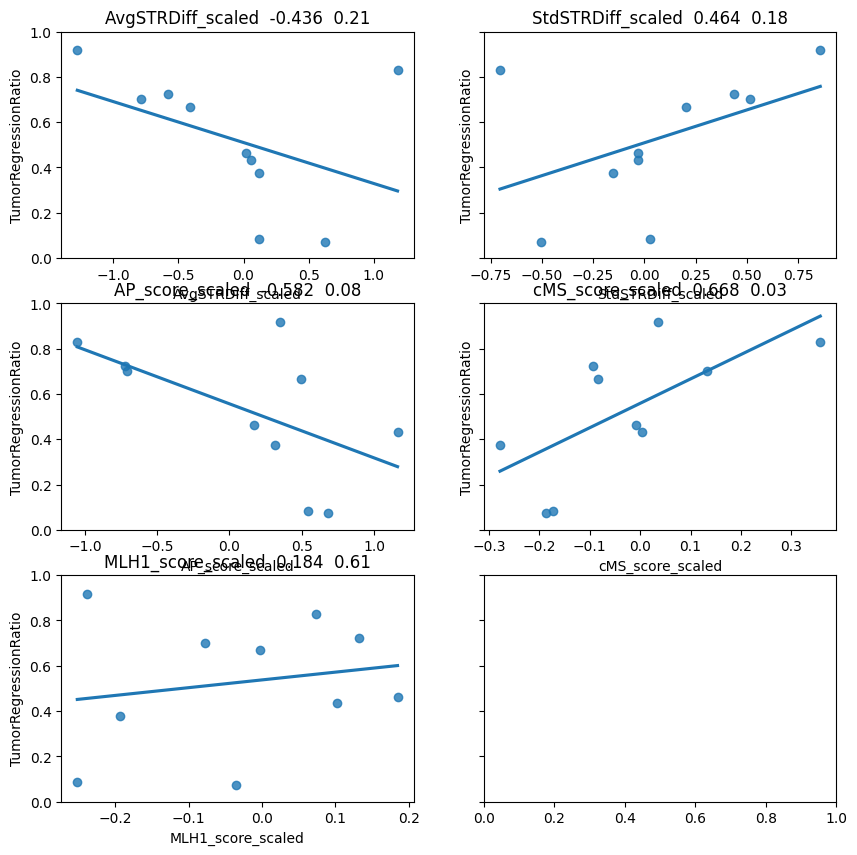

In [484]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharey=True)

f = sns.regplot(data=SummaryByPatient, x='AvgSTRDiff_scaled', y='TumorRegressionRatio', robust=False, ci=None, ax=axes[0, 0])
r, pval = stats.pearsonr(SummaryByPatient['AvgSTRDiff_scaled'], SummaryByPatient['TumorRegressionRatio'])
f.set_ylim([0, 1]);
f.set_title(f'AvgSTRDiff_scaled  {round(r, 3)}  {round(pval, 2)}')

f = sns.regplot(data=SummaryByPatient, x='StdSTRDiff_scaled', y='TumorRegressionRatio', robust=False, ci=None, ax=axes[0, 1])
r, pval = stats.pearsonr(SummaryByPatient['StdSTRDiff_scaled'], SummaryByPatient['TumorRegressionRatio'])
f.set_ylim([0, 1]);
f.set_title(f'StdSTRDiff_scaled  {round(r, 3)}  {round(pval, 2)}')

f = sns.regplot(data=SummaryByPatient, x='AP_score_scaled', y='TumorRegressionRatio', robust=False, ci=None, ax=axes[1, 0])
r, pval = stats.pearsonr(SummaryByPatient['AP_score_scaled'], SummaryByPatient['TumorRegressionRatio'])
f.set_ylim([0, 1]);
f.set_title(f'AP_score_scaled  {round(r, 3)}  {round(pval, 2)}')

f = sns.regplot(data=SummaryByPatient, x='cMS_score_scaled', y='TumorRegressionRatio', robust=False, ci=None, ax=axes[1, 1])
r, pval = stats.pearsonr(SummaryByPatient['cMS_score_scaled'], SummaryByPatient['TumorRegressionRatio'])
f.set_ylim([0, 1]);
f.set_title(f'cMS_score_scaled  {round(r, 3)}  {round(pval, 2)}')

f = sns.regplot(data=SummaryByPatient, x='MLH1_score_scaled', y='TumorRegressionRatio', robust=False, ci=None, ax=axes[2, 0])
r, pval = stats.pearsonr(SummaryByPatient['MLH1_score_scaled'], SummaryByPatient['TumorRegressionRatio'])
f.set_ylim([0, 1]);
f.set_title(f'MLH1_score_scaled  {round(r, 3)}  {round(pval, 2)}')

In [488]:
SummaryByPatient['RandomNoise1'] = [ random.randint(0, 100)/100 for i in range(len(SummaryByPatient)) ]
SummaryByPatient['RandomNoise2'] = [ random.randint(0, 100)/100 for i in range(len(SummaryByPatient)) ]
SummaryByPatient

,PatientID,AvgSTRDiff_scaled,StdSTRDiff_scaled,AP_score_scaled,cMS_score_scaled,MLH1_score_scaled,TumorRegressionRatio,PredictedRegressionRatio,RandomNoise1,RandomNoise2
0,P04,-1.276409,0.858311,0.350338,0.035965,-0.237983,0.9180,0.819278,0.37,0.06
6,P21,-0.787797,0.515082,-0.706316,0.132804,-0.077978,0.7013,0.950664,0.23,0.56
8,P23,-0.576846,0.438378,-0.722448,-0.094176,0.131938,0.7223,0.621959,0.36,0.15
7,P22,-0.410305,0.204990,0.494750,-0.082964,-0.002172,0.6679,0.547887,0.34,0.19
4,P19,0.020289,-0.032616,0.170413,-0.008475,0.184694,0.4619,0.533193,0.22,0.54
5,P20,0.060151,-0.032484,1.163129,0.003008,0.102669,0.4336,0.401172,0.37,0.29
9,P26,0.114935,-0.153733,0.316374,-0.278094,-0.193528,0.3760,0.257666,0.30,0.48
1,P15,0.119380,0.025679,0.546082,-0.172542,-0.251800,0.0850,0.203559,0.46,0.49
2,P17,0.627525,-0.502518,0.682308,-0.187713,-0.036030,0.0725,0.203965,0.48,0.06
3,P18,1.182326,-0.703850,-1.052761,0.357425,0.073925,0.8295,0.728656,0.97,0.95


Coefficients: a=-0.7158871382056748, b=-0.7494490044720972, c=-0.11622534912241475, d=1.0443567516040841
Intercept: 0.5519315393844447
0.892 0.00053


' \nCoefficients: a=-1.0298031058176842, b=-1.80990053320075, c=-0.2703198354925987, d=0.6236925119850045\nIntercept: 1.0387831020823701\n0.887 0.00061\n'

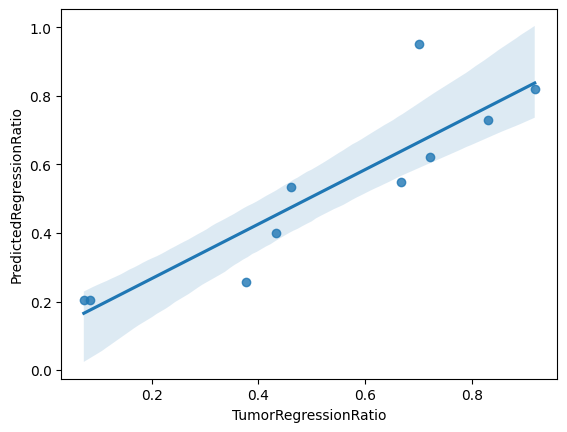

In [487]:
# Example data
null_values = [ 0 for i in range(len(SummaryByPatient)) ]

data = {
    "x": list(SummaryByPatient['AvgSTRDiff_scaled']),
    "y": list(SummaryByPatient['StdSTRDiff_scaled']),
    "z": list(SummaryByPatient['AP_score_scaled']),
    "w": list(SummaryByPatient['cMS_score_scaled']),

    # "w": null_values,
    "v": list(SummaryByPatient['TumorRegressionRatio']),

}
# Create a DataFrame
df = pd.DataFrame(data)

# Features (x, y, z, w) and target (v)
X = df[["x", "y", "z", "w"]]
y = df["v"]

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Coefficients
a, b, c, d = model.coef_
intercept = model.intercept_

print(f"Coefficients: a={a}, b={b}, c={c}, d={d}")
print(f"Intercept: {intercept}")

def PredictRegression( x,y,z,w, a,b,c,d,intercept ):
    return a*x + b*y + c*z + d*w + intercept

SummaryByPatient['PredictedRegressionRatio'] = [ PredictRegression(tup.AvgSTRDiff_scaled, tup.StdSTRDiff_scaled, tup.AP_score_scaled, tup.cMS_score_scaled,
                                                              a,b,c,d,intercept) for tup in SummaryByPatient.itertuples() ]

sns.regplot(data=SummaryByPatient, x='TumorRegressionRatio', y='PredictedRegressionRatio')
r, pval = stats.pearsonr(SummaryByPatient['PredictedRegressionRatio'], SummaryByPatient['TumorRegressionRatio'])
print(round(r, 3), round(pval, 5))
f.set_xlim([0, 1]);
f.set_ylim([0, 1]);

# x 0.818 0.00382
# y 0.866 0.00121
# z 0.252 0.48313
# w 0.804 0.00504
# v 0.449 0.1928

""" 
Coefficients: a=-1.0298031058176842, b=-1.80990053320075, c=-0.2703198354925987, d=0.6236925119850045
Intercept: 1.0387831020823701
0.887 0.00061
"""

In [486]:
loo = LeaveOneOut()
model = LinearRegression()
mse_scores = list()
list_pvals = list()
list_rvals = list()

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, y_pred))
    
print(f"Average MSE: {np.mean(mse_scores)}")
print(np.var(y))

Average MSE: 0.2785164022238599
0.07704590600000001


<Axes: xlabel='PredictedRegressionRatio', ylabel='TumorRegressionRatio'>

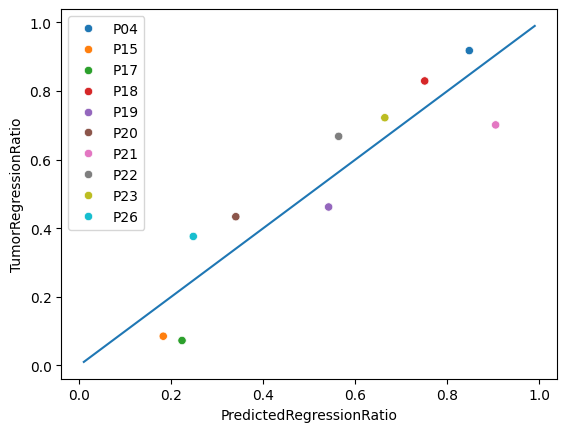

In [453]:
sns.scatterplot(data=SummaryByPatient, x='PredictedRegressionRatio', y='TumorRegressionRatio', hue='PatientID')
sns.lineplot(x=[i/100 for i in range(1, 100)], y=[i/100 for i in range(1, 100)])